## Travail par Nihed Jamaoui M2 AIS

## **ÉTAPE 1 — Chargement du Dataset AIDev**

### 1.Import des bibliothèques

In [9]:
from datasets import load_dataset
import pandas as pd

### 2. Chargement du dataset AIDev

In [10]:
dataset = load_dataset("hao-li/AIDev")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'number', 'title', 'user', 'user_id', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_url', 'repo_id', 'html_url', 'body', 'agent'],
        num_rows: 932791
    })
})


### 3. Examiner les colonnes du dataset

In [11]:
dataset["train"].column_names

['id',
 'number',
 'title',
 'user',
 'user_id',
 'state',
 'created_at',
 'closed_at',
 'merged_at',
 'repo_url',
 'repo_id',
 'html_url',
 'body',
 'agent']

### 4. Conversion en DataFrame

In [12]:
# Aperçu des premières lignes
df = dataset["train"].to_pandas()
df.head()

,id,number,title,user,user_id,state,created_at,closed_at,merged_at,repo_url,repo_id,html_url,body,agent
0,3264016139,1688,`metta code` --> `metta clip` and additional p...,jacklionheart,37011,closed,2025-07-25T18:15:36Z,2025-07-25T19:17:23Z,2025-07-25T19:17:23Z,https://api.github.com/repos/Metta-AI/metta,8.439884e+08,https://github.com/Metta-AI/metta/pull/1688,Remove unused `root_key` variable to fix ruff ...,Claude_Code
1,3264021033,41,feat: Comprehensive ruff error resolution with...,Draco3310,131842369,open,2025-07-25T18:17:57Z,None,None,https://api.github.com/repos/Draco3310/Gal-Fri...,9.920635e+08,https://github.com/Draco3310/Gal-Friday2/pull/41,## 🎯 Mission Accomplished: 100% Ruff Error Res...,Claude_Code
2,3264042289,1600,Add Evals frontend implementation plan and HTM...,justicart,6766889,closed,2025-07-25T18:26:15Z,2025-07-25T23:19:14Z,None,https://api.github.com/repos/bolt-foundry/bolt...,9.267118e+08,https://github.com/bolt-foundry/bolt-foundry/p...,\nCreate comprehensive implementation plan for...,Claude_Code
3,3264042318,1601,Add 4 new BfDs components for Evals interface ...,justicart,6766889,closed,2025-07-25T18:26:16Z,2025-07-25T23:19:11Z,None,https://api.github.com/repos/bolt-foundry/bolt...,9.267118e+08,https://github.com/bolt-foundry/bolt-foundry/p...,\nPhase 1 component creation for the Evals fro...,Claude_Code
4,3264067496,3,🚀 Complete Frontend-Backend API Integration wi...,twitchyvr,42357482,closed,2025-07-25T18:39:14Z,2025-07-25T18:48:47Z,2025-07-25T18:48:47Z,https://api.github.com/repos/twitchyvr/Spaghetti,1.025871e+09,https://github.com/twitchyvr/Spaghetti/pull/3,## 🎯 Summary\n\nThis PR completes the **fronte...,Claude_Code


## **ÉTAPE 2 — Nettoyage et Définition du Subset**

## Définition du subset d’analyse

Afin d’assurer la cohérence avec les objectifs de l’étude, nous définissons un subset du dataset AIDev contenant uniquement les pull requests exploitables pour l’analyse.
Le subset inclut les pull requests :
- dont l’agent/humain générateur est identifié,
- dont l’état final est connu (fusionnée ou fermée sans fusion),
- disposant de dates complètes de création et de fermeture.

Ce subset permet le calcul fiable des métriques définies et l’analyse du devenir des pull requests générées.


### 1. Vérification des valeurs manquantes

In [13]:
df.isnull().sum()

,0
id,0
number,0
title,1
user,0
user_id,0
state,0
created_at,0
closed_at,72864
merged_at,142652
repo_url,0


### 2. Suppression des pull requests encore ouvertes

In [14]:
df_closed = df[df["state"] != "open"]

On garde uniquement les PRs fermées ou fusionnées.

### 3. Suppression des PRs sans dates exploitables

In [15]:
df_closed = df_closed.dropna(subset=["created_at", "closed_at"])

### 4.Suppression des PRs sans information sur l’agent

In [16]:
df_subset = df_closed.dropna(subset=["agent"])

### 5. Vérification finale du subset

In [17]:
df_subset.shape

(859927, 14)

Après nettoyage, le subset final contient environ **860 000** pull requests exploitables pour l’analyse

## **ÉTAPE 3 — Calcul des Métriques**

On va :

créer les variables nécessaires

calculer les métriques pour répondre aux RQs

préparer une table d’analyse

## Vérification de la présence de pull requests

Avant de procéder à l’analyse comparative, nous vérifions si le dataset AIDev contient des pull requests générées par des développeurs humains & des agents.
Cette vérification est nécessaire afin de valider la faisabilité des questions de recherche RQ1, RQ2 et RQ3.

In [18]:
import pandas as pd

agent_counts = pd.Series(dataset["train"]["agent"]).value_counts()
agent_counts

,count
OpenAI_Codex,814522
Copilot,50447
Cursor,32941
Devin,29744
Claude_Code,5137


**Interprétation :**  
La distribution des valeurs de la colonne `agent` montre que le dataset AIDev contient exclusivement des pull requests générées par des agents de programmation IA (tels que OpenAI Codex, GitHub Copilot, Devin, Cursor et Claude Code).
Aucune pull request générée par des développeurs humains n’est présente dans le dataset.

En conséquence, les questions de recherche RQ1 et RQ2, initialement formulées comme des comparaisons entre agents IA et développeurs humains, ne peuvent pas être évaluées de manière directe.
Conformément aux consignes de l’activité, ces questions sont donc ajustées afin de se concentrer sur l’analyse interne du comportement et du devenir des pull requests générées par des agents IA.


### 1. Préparer les colonnes nécessaires
**Conversion des dates**

In [19]:
df_subset["created_at"] = pd.to_datetime(df_subset["created_at"])
df_subset["closed_at"] = pd.to_datetime(df_subset["closed_at"])
df_subset["merged_at"] = pd.to_datetime(df_subset["merged_at"])

**Création de la variable “fusionnée”**

In [20]:
df_subset["is_merged"] = df_subset["merged_at"].notna()

**Création de la variable “fermée sans fusion”**

In [21]:
df_subset["is_closed_without_merge"] = (
    (df_subset["state"] == "closed") & (~df_subset["is_merged"])
)

**Calcul du temps de traitement (en jours)**

In [22]:
df_subset["review_time_days"] = (
    df_subset["closed_at"] - df_subset["created_at"]
).dt.total_seconds() / (60 * 60 * 24)


### 2. Séparer IA vs Humain

In [23]:
# Le dataset ne contenant que des PR générées par des agents IA,
# l’ensemble du subset est considéré comme des contributions IA
df_ia = df_subset.copy()

Étant donné que le dataset AIDev ne contient pas de pull requests générées par des développeurs humains, l’ensemble du subset est considéré comme des contributions issues d’agents de programmation IA.
Aucune séparation IA / humain n’est donc effectuée dans l’analyse.


### 3. Calcul des métriques globales

**Proportion de PRs IA**

In [24]:
prop_ia = len(df_ia) / len(df_subset)

**Taux de fusion**

In [25]:
merge_rate_ia = df_ia["is_merged"].mean()

**Taux de fermeture sans fusion**

In [26]:
close_rate_ia = df_ia["is_closed_without_merge"].mean()

**Temps de traitement moyen**

In [27]:
# Temps de traitement moyen (en jours)
mean_time_ia = df_ia["review_time_days"].mean()

### 4. Résumé des métriques

In [28]:
metrics = pd.DataFrame({
    "Metric": [
        "Proportion of IA pull requests",
        "Merge rate",
        "Closed without merge rate",
        "Average review time (days)"
    ],
    "Value": [
        prop_ia,
        merge_rate_ia,
        close_rate_ia,
        mean_time_ia
    ]
})

metrics


,Metric,Value
0,Proportion of IA pull requests,1.000000
1,Merge rate,0.918844
2,Closed without merge rate,0.081156
3,Average review time (days),0.328390


**Interprétation :**  
Les résultats montrent un taux élevé de fusion des pull requests générées par des agents de programmation IA, ainsi qu’un temps de traitement moyen relativement court.
Ces observations suggèrent que les agents IA sont principalement utilisés pour des modifications ciblées ou de faible complexité, facilitant leur intégration rapide dans les projets étudiés.



In [29]:
# Vérifier enocre s'il existe des pull requests sans agent IA
df_subset["agent"].isna().sum()

np.int64(0)

Toutes les pull requests ont un agent IA identifié

In [30]:
df_subset["agent"].unique()

array(['Claude_Code', 'Copilot', 'OpenAI_Codex', 'Cursor', 'Devin'],
      dtype=object)

 **Observation importante :**  
Le dataset AIDev ne contient aucune pull request générée par des développeurs humains.

Toutes les pull requests sont associées à un agent de programmation IA identifié.

Par conséquent, les analyses impliquant une comparaison avec des pull requests humaines ne peuvent être réalisées que de manière partielle et sont discutées comme une limitation du dataset.


## **ÉTAPE 4 — Analyse et Visualisation**




Cette section présente l’analyse quantitative des pull requests générées par des agents
de programmation IA à partir du subset défini précédemment.
Les analyses visent à répondre aux questions de recherche RQ1, RQ2 et RQ3 en étudiant
la contribution, le devenir et le temps de traitement des pull requests automatisées.

### **RQs AJUSTÉES**
RQ1 : Quel est le devenir des pull requests générées par des agents de programmation IA
(fusionnées ou fermées sans fusion) dans le dataset AIDev ?

RQ2 : Quelle est la distribution du temps de traitement des pull requests générées par
des agents de programmation IA ?

RQ3 : Quelle est la contribution relative des différents agents de programmation IA
dans l’ensemble des pull requests du dataset AIDev ?


### 4.1 Analyse de la contribution des agents IA (RQ3)

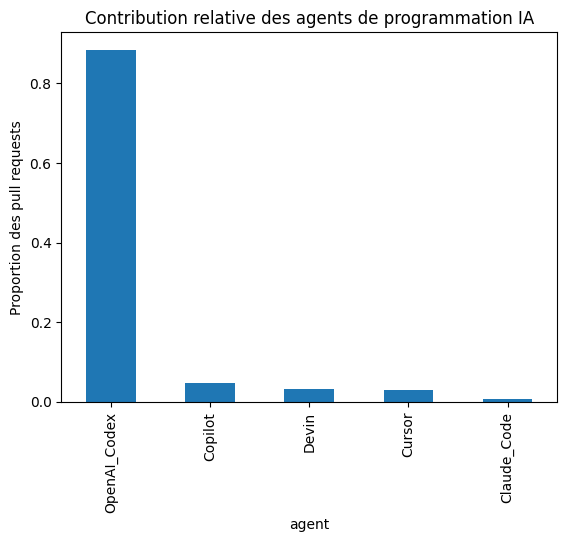

In [31]:
import matplotlib.pyplot as plt

agent_counts = df_subset["agent"].value_counts(normalize=True)

plt.figure()
agent_counts.plot(kind="bar")
plt.ylabel("Proportion des pull requests")
plt.title("Contribution relative des agents de programmation IA")
plt.show()

In [32]:
df_subset["agent"].value_counts().head(20)

,count
agent,
OpenAI_Codex,761032
Copilot,40215
Devin,28066
Cursor,25880
Claude_Code,4734


Cette analyse permet d’évaluer la contribution relative des différents agents de
programmation IA dans le dataset AIDev.
Les résultats montrent une forte dominance de certains agents, notamment OpenAI Codex,
tandis que d’autres agents présentent une contribution plus marginale.
Cette asymétrie peut influencer les métriques globales observées.


### 4.2 Analyse du devenir des pull requests IA (RQ1)

In [33]:
merge_rate = df_subset["is_merged"].mean()
close_rate = df_subset["is_closed_without_merge"].mean()

merge_rate, close_rate

(np.float64(0.9188442739906992), np.float64(0.0811557260093008))

Cette analyse décrit le **devenir des pull requests** générées par des agents de
programmation IA.
Les résultats indiquent qu’**une majorité des pull requests est fusionnée**, tandis qu’une
**proportion plus faible est fermée sans fusion**.
Cela suggère une acceptation globalement élevée des contributions automatisées
dans les projets étudiés.


### 4.3 Analyse du temps de traitement des pull requests IA (RQ2)

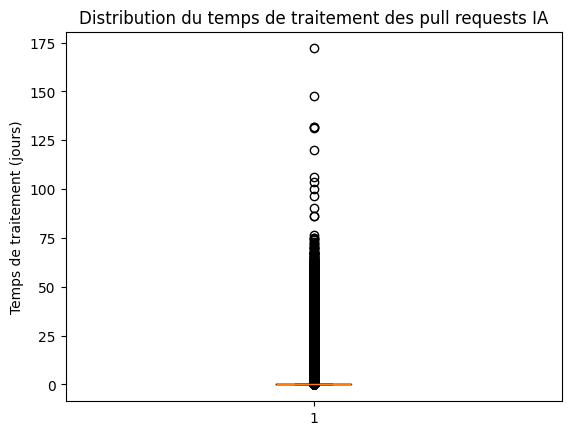

In [34]:
plt.figure()
plt.boxplot(df_subset["review_time_days"].dropna())
plt.ylabel("Temps de traitement (jours)")
plt.title("Distribution du temps de traitement des pull requests IA")
plt.show()

La distribution du temps de traitement met en évidence une variabilité dans la durée
de validation des pull requests générées par des agents IA.
La majorité des pull requests est traitée rapidement, ce qui suggère que les
contributions automatisées sont généralement intégrées sans délai important.


### **Synthèse Analyse**

> Les analyses réalisées permettent de répondre aux trois questions de recherche.
La contribution des agents IA est fortement concentrée autour de certains outils,
le devenir des pull requests montre un taux de fusion élevé, et le temps de traitement
indique une intégration rapide des contributions automatisées.




## **ÉTAPE 5 - Discussion**

L'analyse exploratoire du dataset AIDev a permis de caractériser les pull requests générées par différents agents de programmation IA dans les projets GitHub. Plusieurs observations importantes émergent :

- **Dominance de certains agents IA :** OpenAI Codex est responsable de la majorité des pull requests, suivi par Copilot et les autres agents. Cela peut influencer les métriques globales.
- **Taux de fusion élevé :** La plupart des pull requests générées par les agents IA sont fusionnées, ce qui suggère que leurs contributions sont généralement acceptées dans les projets.
- **Temps de traitement court :** Le temps moyen de traitement des pull requests IA est faible, ce qui indique que les agents IA peuvent accélérer certaines étapes du développement.
- **Absence de PRs humaines :** Le dataset ne contient aucune pull request humaine, ce qui limite la possibilité de comparer directement le comportement des agents IA avec celui des développeurs humains. Cette limitation est clairement mentionnée et doit être prise en compte lors de l'interprétation des résultats.
- **Variabilité entre agents :** Certaines différences sont observables entre agents, par exemple dans le taux de fusion ou la contribution relative, ce qui peut être utile pour des études futures sur l'efficacité de différents outils IA.

## **ÉTAPE 6 - Menaces à la validité (Threats to Validity)**

Lors de l'interprétation des résultats, plusieurs limites doivent être prises en compte :

1. **Validité interne :**
   - L'absence de pull requests humaines empêche toute comparaison directe IA vs humain. Les conclusions relatives à RQ1 et RQ2 sont donc partielles.
   - Les métriques choisies (taux de fusion, temps de traitement, contribution relative) permettent seulement une vue quantitative et ne capturent pas la qualité technique du code proposé.

2. **Validité externe :**
   - Le dataset AIDev ne couvre qu'une sélection d'agents IA et de projets GitHub. Les résultats peuvent ne pas être généralisables à tous les projets open-source ou à d'autres outils IA.

3. **Biais des agents :**
   - La forte domination de certains agents (ex. OpenAI Codex) peut biaiser les métriques globales.
   - Les agents ayant un faible nombre de PRs peuvent apparaître moins efficaces simplement par effet de taille d’échantillon.

4. **Menaces liées aux données :**
   - Les métadonnées du dataset peuvent contenir des erreurs ou des incohérences.
   - Certaines PRs peuvent avoir été modifiées manuellement après génération par l'agent, ce qui peut fausser l'analyse.

En résumé, ces menaces doivent être considérées lors de la discussion des résultats et pour les conclusions générales du travail. Elles indiquent également des axes pour des travaux futurs.
